In [1]:
# import main tcdf module
import src.main_tcdf as main_tcdf
import src.main_tigramite as main_tigramite

# utilities library
import os, sys
import glob
from pathlib import Path
import pickle as pkl
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TRAIN_AND_RUN = False # set True to train and run both models (TCDF, Tigramite), False to just run the models from saved files

Dataset shape: (13309, 12)
Variables: ['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth', 'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque']


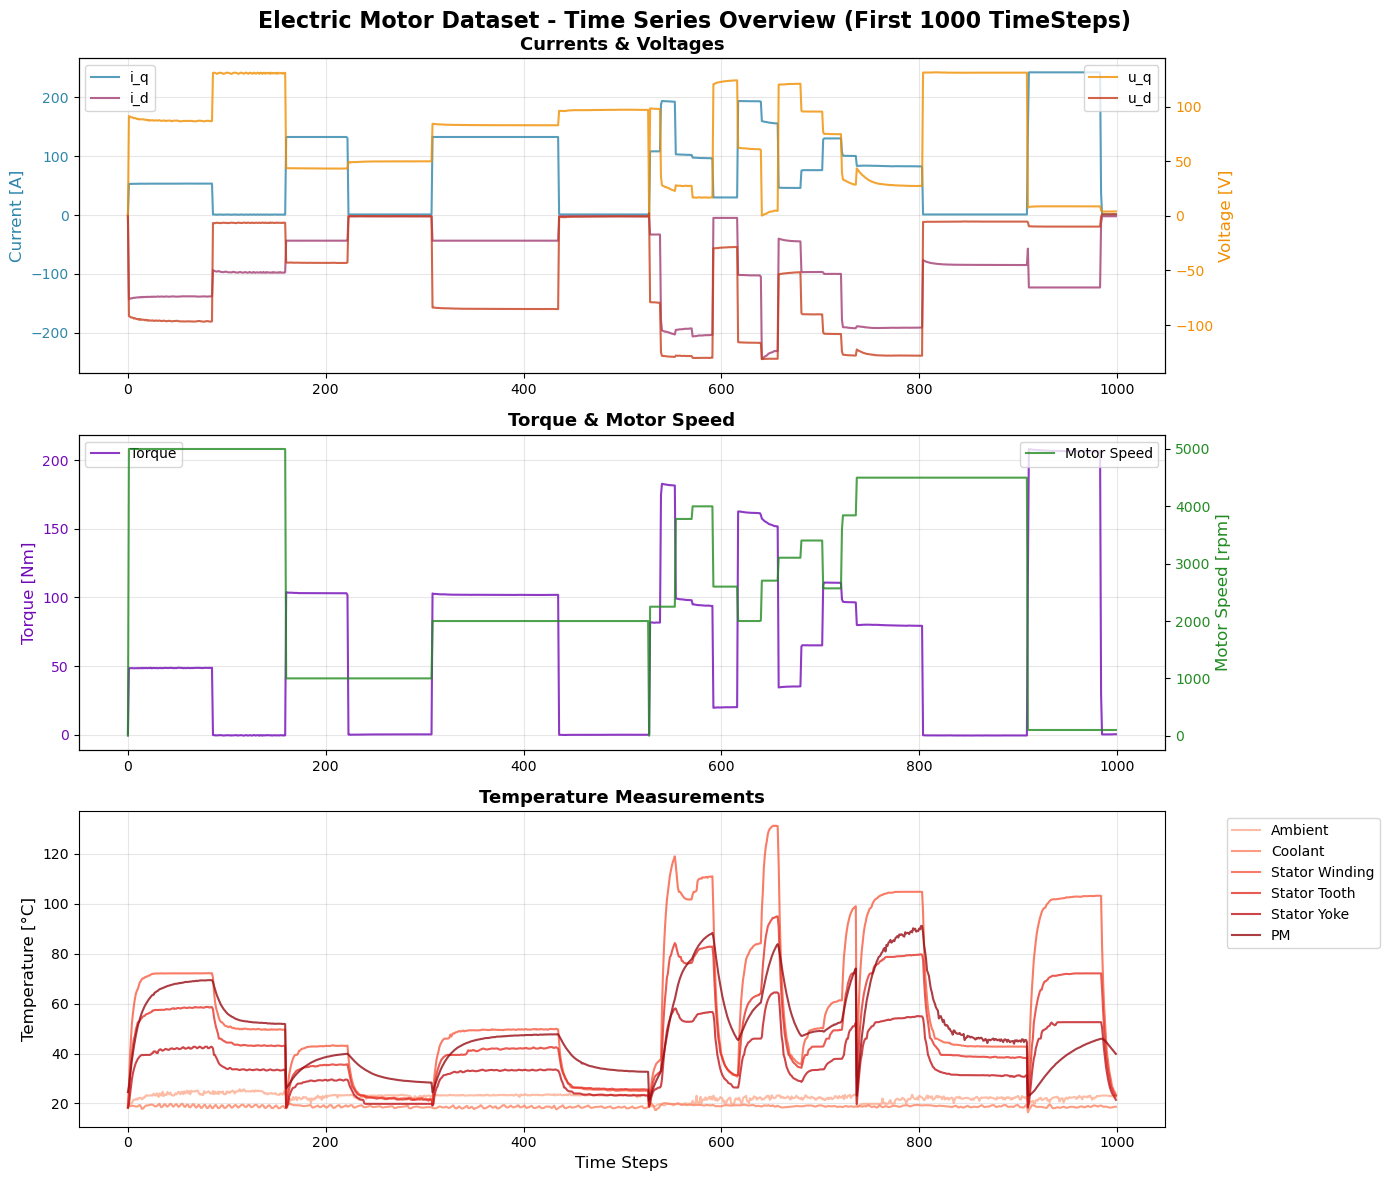

In [3]:
# Load dataset
df = pd.read_csv('data/single/dataset_em.csv')
print(f"Dataset shape: {df.shape}")
print(f"Variables: {list(df.columns)}")

# Take first 1000 points for visualization
df_viz = df.head(1000)
time_steps = np.arange(len(df_viz))

# Set style and color palette
plt.style.use('default')
colors_electric = ['#2E86AB', '#A23B72']  # Blue for currents
colors_voltage = ['#F18F01', '#C73E1D']   # Orange for voltages
colors_mech = ['#7209B7', '#228B22']      # Purple/geen for mechanical
colors_temp = plt.cm.Reds(np.linspace(0.3, 0.9, 6))  # Heat scale for temperatures

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Electric Motor Dataset - Time Series Overview (First 1000 TimeSteps)', 
             fontsize=16, fontweight='bold', y=0.98)

# Subplot 1: Electrical quantities (currents + voltages)
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Plot currents on left axis
ax1.plot(time_steps, df_viz['i_q'], color=colors_electric[0], linewidth=1.5, label='i_q', alpha=0.8)
ax1.plot(time_steps, df_viz['i_d'], color=colors_electric[1], linewidth=1.5, label='i_d', alpha=0.8)
ax1.set_ylabel('Current [A]', fontsize=12, color=colors_electric[0])
ax1.tick_params(axis='y', labelcolor=colors_electric[0])
ax1.legend(loc='upper left')

# Plot voltages on right axis
ax1_twin.plot(time_steps, df_viz['u_q'], color=colors_voltage[0], linewidth=1.5, label='u_q', alpha=0.8)
ax1_twin.plot(time_steps, df_viz['u_d'], color=colors_voltage[1], linewidth=1.5, label='u_d', alpha=0.8)
ax1_twin.set_ylabel('Voltage [V]', fontsize=12, color=colors_voltage[0])
ax1_twin.tick_params(axis='y', labelcolor=colors_voltage[0])
ax1_twin.legend(loc='upper right')

ax1.set_title('Currents & Voltages', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Subplot 2: Mechanical quantities
ax2 = axes[1]
ax2_twin = ax2.twinx()

# Plot torque on left axis
ax2.plot(time_steps, df_viz['torque'], color=colors_mech[0], linewidth=1.5, label='Torque', alpha=0.8)
ax2.set_ylabel('Torque [Nm]', fontsize=12, color=colors_mech[0])
ax2.tick_params(axis='y', labelcolor=colors_mech[0])
ax2.legend(loc='upper left')

# Plot motor speed on right axis
ax2_twin.plot(time_steps, df_viz['motor_speed'], color=colors_mech[1], linewidth=1.5, label='Motor Speed', alpha=0.8)
ax2_twin.set_ylabel('Motor Speed [rpm]', fontsize=12, color=colors_mech[1])
ax2_twin.tick_params(axis='y', labelcolor=colors_mech[1])
ax2_twin.legend(loc='upper right')

ax2.set_title('Torque & Motor Speed', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Subplot 3: Temperature measurements
ax3 = axes[2]
temp_vars = ['ambient', 'coolant', 'stator_winding', 'stator_tooth', 'stator_yoke', 'pm']
temp_labels = ['Ambient', 'Coolant', 'Stator Winding', 'Stator Tooth', 'Stator Yoke', 'PM']

for i, (var, label) in enumerate(zip(temp_vars, temp_labels)):
    ax3.plot(time_steps, df_viz[var], color=colors_temp[i], linewidth=1.5, 
             label=label, alpha=0.8)

ax3.set_ylabel('Temperature [°C]', fontsize=12)
ax3.set_xlabel('Time Steps', fontsize=12)
ax3.set_title('Temperature Measurements', fontsize=13, fontweight='bold')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

## Dataset Description

The electric motor temperature dataset contains 12 time series variables from a permanent magnet synchronous motor (PMSM) under various operating conditions. The dataset comprises:

**Electrical quantities**: Currents $i_q, i_d \in [-200, 200]$ A and voltages $u_q, u_d \in [-100, 100]$ V in the dq reference frame.

**Mechanical quantities**: Motor speed $\omega \in [0, 4500]$ rpm and torque $T \in [0, 200]$ Nm.

**Thermal quantities**: Six temperature measurements $T_{amb}, T_{cool}, T_{sw}, T_{st}, T_{sy}, T_{pm} \in [20, 130]$ °C representing ambient, coolant, stator winding, stator tooth, stator yoke, and permanent magnet temperatures.

The time series exhibit step-wise operational patterns corresponding to different motor setpoints, creating a natural experimental design for causal inference. Key physical relationships expected include:

- Electromagnetic coupling: $(i_q, i_d) \leftrightarrow (u_q, u_d)$ via motor dynamics
- Mechanical coupling: $T \leftrightarrow \omega$ through load characteristics  
- Thermal coupling: Electrical/mechanical losses → temperature rise $
- Thermal inertia: Different thermal masses lead to varied response times ($\tau_{pm} < \tau_{st} < \tau_{sy}$)
- Confounding effects: $T_{amb}$ and $T_{cool}$ act as common drivers affecting all thermal measurements

Data were collected over 185+ hours at 2 Hz sampling rate. A subsampling every 10 timesteps was applied to reduce computational load while preserving information content, as confirmed by the step-wise patterns visible in the plots.

## TCDF Methodology

### Framework Overview

The Temporal Causal Discovery Framework (TCDF) employs attention-based convolutional neural networks to discover causal relationships in multivariate time series. The framework operates through four sequential steps:

![TCDF Overview](images/tcdf_overview.png)
*Figure: TCDF workflow from time series data to temporal causal graph*

### Network Architecture: AD-DSTCNs

TCDF uses N independent Attention-based Dilated Depthwise Separable Temporal Convolutional Networks (AD-DSTCNs), where each network $N_j$ predicts target series $X_j$ using all series as input.

![AD-DSTCN Architecture](images/ad_dstcn_architecture.png)
*Figure: AD-DSTCN architecture with attention mechanism and depthwise separable convolutions*

**Key architectural components:**

**Dilated Convolutions**: Enable exponential receptive field growth with linear parameter increase:
$$R_{D-TCN} = 1 + \sum_{l=0}^{L} (K-1) \cdot c^l$$
where $K$ is kernel size, $L$ is number of layers, $c$ is dilation coefficient.

**Attention Mechanism**: Each network $N_j$ learns attention vector $\mathbf{a}_j = [a_{1,j}, a_{2,j}, ..., a_{N,j}]$ where $a_{i,j}$ represents how much $N_j$ attends to input series $X_i$ when predicting $X_j$.

**Depthwise Separable Architecture**: Maintains input channel separation to enable interpretable attention weights and delay discovery.

### Causal Discovery Process

1. **Time Series Prediction**: Train AD-DSTCNs to minimize prediction loss $\mathcal{L}$ between actual $X_j$ and predicted $\hat{X}_j$

2. **Attention Interpretation**: Convert soft attention to potential causes using HardSoftmax:
   $$h_{i,j} = \begin{cases} 
   \sigma(a_{i,j}) & \text{if } \sigma(a_{i,j}) \geq \tau_j \\
   0 & \text{otherwise}
   \end{cases}$$

3. **Causal Validation**: Apply Permutation Importance Validation Method (PIVM) to distinguish causation from correlation by testing prediction degradation under input permutation

4. **Delay Discovery**: Extract time delays from kernel weights $W_i$ by identifying position of maximum weight magnitude

The framework outputs a temporal causal graph $G = (V, E)$ where edges $e_{i,j} \in E$ represent causal relationships with associated delays $d(e_{i,j})$.

In [4]:
# TCDF Parameters
tcdf_params = {
    'kernel_size': 20,
    'dilation_c': 20,  # kernel_size
    'levels': 1,
    'epochs': 2500,
    'learning_rate': 0.001,
    'optimizer': 'RMSprop',  # Adam or RMSprop
    'significance': 0.8,
    'log_interval': 500,
    'seed': 1111,
    'cuda': True
}

# CSV data folder
data_folder = 'data/multi/'
csv_files = glob.glob(os.path.join(data_folder, '*.csv'))

# Run TCDF analysis
save_path = 'log/'
save_data = os.path.join(save_path, 'data')
if TRAIN_AND_RUN:
    results_tcdf = main_tcdf.main(csv_files, tcdf_params, save_path=save_path)
else:
    # Load precomputed results if not training
    with open(os.path.join(save_data, 'results_tcdf.pkl'), 'rb') as f:
        results_tcdf = pkl.load(f)

# Extract and save results
if TRAIN_AND_RUN:
    with open(os.path.join(save_data, 'results_tcdf.pkl'), 'wb') as f:
        pkl.dump(results_tcdf, f)
    print(f"Resulting graph saved in: log/results_tcdf.csv")
allcauses, alldelays, allreallosses, allscores, columns = results_tcdf


print(f"Analysis Completed! A total of {len(alldelays)} causal relation has been found.\n")
print('-' * 24 + ' CAUSES ' + '-' * 24)
# Display Causal Relations
for pair in alldelays:
    print("- ",columns[pair[1]], "causes", columns[pair[0]], 
          "with a delay of", alldelays[pair], "time steps.")

Analysis Completed! A total of 8 causal relation has been found.

------------------------ CAUSES ------------------------
-  stator_tooth causes coolant with a delay of 4 time steps.
-  stator_yoke causes coolant with a delay of 0 time steps.
-  stator_tooth causes stator_winding with a delay of 0 time steps.
-  stator_winding causes stator_tooth with a delay of 0 time steps.
-  torque causes i_d with a delay of 0 time steps.
-  torque causes i_q with a delay of 0 time steps.
-  stator_tooth causes stator_yoke with a delay of 0 time steps.
-  i_q causes torque with a delay of 0 time steps.


## TCDF Limitations

### Known Limitations (from original paper)

**Experimental scope:**
- Limited evaluation on only 2 benchmarks (financial + FMRI data), raising questions about generalizability across different domains and time series characteristics. Additionally, no dynamic operational datasets have been tested and validated, bringing doubt on the methodology's effectiveness for real-world environments with time-varying system dynamics and operational regime changes.
- Tested exclusively on stationary time series with small delays (1-3 timesteps), limiting applicability to systems with longer-term dependencies or non-stationary dynamics
- No feedback loops except self-causation, which is unrealistic for many real-world systems where bidirectional causality is common (e.g., economic systems, biological networks)

**Data requirements:**
- Performance degrades on short time series (<1000 timesteps) due to deep learning's inherent need for large parameter spaces and sufficient training samples
- Requires more data than traditional statistical methods for reliable causal inference, creating a practical barrier for many applications where long time series are unavailable

**Methodological constraints:**
- Hyperparameter selection, particularly the number of hidden layers L, becomes a critical but difficult choice without prior knowledge of the underlying causal structure's temporal complexity
- Receptive field constraint $R_{D-TCN} \geq d_{max}$ creates a fundamental architectural limitation: the network must be designed with sufficient temporal scope to capture the longest expected causal delay, requiring domain expertise or extensive hyperparameter search






### Additional Limitations: 

#### 1. Non-Stationary Systems and Dynamic Environments

**Non-stationarity gap**: TCDF was exclusively tested on stationary data, but the transition to non-stationary systems for causal inference is non-trivial. Dynamic systems exhibit time-varying relationships, regime changes, and evolving causal structures that challenge the static network assumptions.

**Architectural limitations for complex relationships**:

The implementation of separate channels through independent AD-DSTCNs creates a fundamental bottleneck. Complex cross-variable relationships that could be captured by 2D kernels are lost because:

$$\text{Conv1D output: } x = \sum_{c=1}^{C} X_c * W_c$$

This simple summation across channels is insufficient to capture multivariate interaction patterns essential for dynamic systems where variables exhibit coupled behaviors (e.g., electromagnetic-thermal coupling in motors).

**Reference**: While convolutional approaches show promise for State Space Models ([Convolutional State Space Models](https://arxiv.org/pdf/2312.00752)), TCDF's channel separation prevents leveraging these advances.

**Delay discovery breakdown in dynamic systems**:

Beyond the effective kernel computation issues, dynamic systems introduce critical sampling-related problems:

- **Sampling frequency mismatch**: High-frequency sampling or slow thermal dynamics requires large receptive fields: $R_{D-TCN} >> d_{thermal}$
- **Model susceptibility**: Large kernels needed for long delays (or high sampling frequency) make the model prone to overfitting and susceptible to noise.

**Implication**: For the electric motor dataset with thermal time constants ∼seconds at 2Hz sampling, discovering meaningful causal delays becomes computationally expensive and methodologically challenging.

#### 2. Flawed Attention Mechanism Design

**Softmax-induced bias and competition artifacts**:

The use of Softmax creates artificial competition between potential causes:
$$\sigma(a_i) = \frac{e^{a_i}}{\sum_{k=1}^N e^{a_k}}$$

This normalization forces the attention to sum to 1, causing:
- **Dominant cause suppression**: Strong causers suppress weaker but genuine causes
- **Artificial sparsity**: The probability distribution property $\sum_{i=1}^N \sigma(a_i) = 1$ conflicts with the reality that multiple independent causes can coexist

**Conceptually flawed initialization logic**:

The paper states: *"all attention scores are initialized as 1... a score will only be increased through backpropagation if the network attends to that time series"*

This reveals fundamental misunderstanding of gradient-based optimization:
- **Gradient dynamics**: Scores can decrease below 1 for important features due to optimization dynamics, not causal irrelevance
- **Arbitrary threshold**: The hard cutoff at τ ≥ 1 means a score of 0.99 is discarded while 1.01 is retained
- **Optimization complexity**: Ignores weight interactions, learning rate effects, and non-convex loss landscapes

**Unjustified architectural constraints**:

The algorithm imposes several arbitrary restrictions:
- **50% maximum causality**: *"At most 50% of the input time series can be a potential cause"* - no theoretical or empirical justification
- **Gap-based thresholding**: Largest gap heuristic ignores the actual magnitude of attention scores
**Minimum causality enforcement**: By requiring the gap cannot be between the highest and second-highest scores, the algorithm artificially forces at least two time series to be labeled as potential causes, regardless of actual causal relevance.

**Implication**: The attention interpretation mechanism introduces more bias than the underlying causal relationships it attempts to discover.

**Proposed improvements**:

To address these fundamental issues, we implemented several architectural modifications:

**1. Softmax to Sigmoid transition**:
```python
# Original problematic approach
attention = F.softmax(self.fs_attention_logits, dim=0)

# Improved independent evaluation
attention = torch.sigmoid(self.fs_attention_logits)
```
Replaced competitive Softmax with independent Sigmoid evaluation to eliminate artificial feature competition. This change allows multiple simultaneous causal relationships and aligns with the channel separation philosophy where each feature should be evaluated independently rather than in zero-sum competition.

**2. LASSO regularization integration**:
```python
def attention_regularization(self):
    """L1 penalty for automatic feature selection during training"""
    attention_scores = self.activ_fn(self.fs_attention_logits)
    return self.lasso_lambda * torch.norm(attention_scores, 1)

# Training loop integration
total_loss = mse_loss + model.attention_regularization()
```
Introduced L1 penalty during training to automatically promote sparsity:
- Eliminates the need for post-hoc arbitrary thresholding
- Provides theoretically grounded feature selection through statistical learning principles  
- Guides attention scores toward zero for irrelevant features during optimization

**3. Zero-centered activation function**:
```python
def activ_fn(self, x):
    """Symmetric, zero-centered activation for causal inference"""
    return torch.abs(2 * torch.sigmoid(x) - 0.5)

# Usage in forward pass
attention_scores = self.activ_fn(self.fs_attention_logits)
```
Developed symmetric activation `abs(2*sigmoid(x)-0.5)` to address sigmoid's fundamental limitations:
- **Symmetry**: Treats positive/negative correlations equally, eliminating directional bias
- **Zero-centered**: True neutrality at f(0) = 0, unlike sigmoid's f(0) = 0.5
- **Magnitude-based**: Responds to |effect| rather than sign, aligning with causal discovery principles
- **LASSO compatibility**: Zero-centered output makes L1 regularization meaningful

**4. Simplified threshold determination**:
```python
print("Attention scores:\n[", end='')
for i, s in enumerate(scores):
    print(f'{s.item():.2e}{str(', ' if i < (len(scores)-1) else '')}', end='')
print(']')    
potentials = [idx for idx, s in enumerate(scores) if s.abs() > 0.2]
print("Potential causes: ", potentials)
```
Replaced the complex gap-based algorithm with straightforward absolute thresholding: `abs(attention) < threshold`. This eliminates:
- Arbitrary 50% maximum causality constraint
- Complex gap-finding heuristics that ignore actual attention magnitudes
- Forced minimum causality requirements

**5. Self-causation mitigation**:
Set target feature to zero in input to prevent trivial self-attention dominance, particularly critical in dynamic systems where self-correlation can mask genuine cross-variable causality.

**Architectural philosophy shift**: From competitive feature selection (softmax) to independent causal evaluation with automatic sparsity (LASSO + zero-centered activation).

#### 3. Scale-Dependent Validation Metric

**Absolute difference-based validation failure**:

The original PIVM validation relies on absolute loss differences to determine causal significance . This approach suffers from fundamental scale-dependency issues:

```python
# Original scale-dependent validation
for idx in potentials:
    random.seed(seed)
    X_test2 = X_train.clone().cpu().numpy()
    random.shuffle(X_test2[:,idx,:][0])
    shuffled = torch.from_numpy(X_test2)
    
    model.eval()
    output = model(shuffled)
    testloss = F.mse_loss(output, Y_train).cpu().data.item()
    
    diff = firstloss - realloss        # Absolute training improvement
    testdiff = firstloss - testloss    # Absolute permutation effect
    
    if testdiff > (diff * significance): 
        validated.remove(idx)  # Scale-dependent threshold fails
```

- **Scale dependency**: When `firstloss` is very large (common in dynamic systems due to initialization, padding, boundary conditions), absolute differences become meaningless
- **Optimization magnitude masking**: Multi-order-of-magnitude loss reductions during training make small but significant permutation effects appear negligible  
- **Threshold calibration impossibility**: No principled way to set `significance` parameter across different loss scales

**Example failure scenario**:
Consider a dynamic system with poor initialization where `firstloss = 1e6`, successful training reaching `realloss = 1e2`, and permutation of an important cause yielding `testloss = 1e3`. Despite the 10x degradation indicating strong causality, the absolute differences `diff ≈ testdiff ≈ 1e6` fail to capture this relationship.

**Proposed ratio-based validation**:


```python
# Calculate scale-invariant improvement ratios
improvement_ratio = float(firstloss) / float(realloss)
print(f'Training improvement ratio: {improvement_ratio:.4f}')

for idx in potentials:
    # Permute potential cause
    random.seed(seed)
    X_test2 = X_test.clone().cpu().numpy()
    random.shuffle(X_test2[:,idx,:][0])
    shuffled = torch.from_numpy(X_test2)
    
    model.eval()
    output = model(shuffled)
    testloss = F.mse_loss(output, Y_test).cpu().data.item()
    
    # Scale-invariant validation
    improvement_ratio_test = float(firstloss) / float(testloss)
    degradation = improvement_ratio / improvement_ratio_test
    
    print(f'Cause {idx}: degradation = {degradation:.2f}')
    if degradation <= 10:  # Interpretable threshold
        validated.remove(idx)
```

To address scale-dependency, we implemented improvement ratio comparison:

1. **Training improvement ratio**: Measures overall model learning capability
2. **Permutation resistance ratio**: Measures model's dependence on specific feature  
3. **Degradation metric**: Quantifies relative causal contribution

**Advantages of ratio-based approach**:
- **Scale-invariant**: Works regardless of absolute loss magnitude
- **Interpretable threshold**: Degradation factor has clear physical meaning
- **Robust to optimization dynamics**: Handles multi-order improvements naturally
- **Quantifiable impact**: Direct measure of causal contribution relative to overall model improvement

**Implication**: Ratio-based validation prevents scale-dependent false negatives, particularly critical in dynamic systems where initialization effects can dominate absolute loss comparisons.

**Additional Critical Issue: Real-time Application Impossibility**

**Instant causation paradox**: The paper claims to discover "instantaneous causal relationships" (τ_min = 0), but this creates a fundamental incompatibility with real-time applications:

- **Prediction requirement**: To estimate variable X_i at time t, the model requires knowledge of all other variables X_j at time t
- **Real-time constraint**: In genuine real-time scenarios, observations at time t arrive sequentially, not simultaneously

**Practical implication**: Any model claiming to discover instant causation cannot be deployed for real-time prediction, as it would require knowing the future state of all other variables to predict a single target variable.

### Tigramite Causal Discovery Framework

**Overview**: Tigramite is a Python package implementing causal discovery algorithms specifically designed for time series data. The core algorithm PCMCI (PC algorithm + Momentary Conditional Independence) combines constraint-based causal discovery with time series-specific conditional independence tests to infer causal relationships across different time lags.

**Methodological approach**: 
- **PC Algorithm**: Iteratively tests conditional independence between variables to construct causal graph
- **Conditional Independence Tests**: Uses various statistical tests (partial correlation, mutual information, etc.) to determine if X ⊥ Y | Z
- **Time-aware discovery**: Explicitly handles temporal dependencies and lagged relationships

**Key Parameters**:

**`tau_max` / `tau_min`**: Define the temporal scope of causal discovery
- `tau_max = 100`: Search for causal relationships up to 100 time steps in the past
- `tau_min = 0`: Include contemporaneous (same-time) causal links
- **Impact**: Larger tau_max increases computational cost but captures longer-term dependencies

**`alpha_level`**: Statistical significance threshold for conditional independence tests
- `alpha_level = 0.01`: Reject independence hypothesis if p-value < 0.01
- **Impact**: Lower values (more stringent) reduce false positives but may miss weaker causal links
- **Trade-off**: Balances Type I vs Type II errors in causal discovery

**`max_combinations`**: Limits conditioning set size in PC algorithm
- `max_combinations = 1`: Test conditional independence with at most 1 conditioning variable
- **Impact**: Higher values improve accuracy by testing more complex conditional dependencies
- **Computational**: Exponentially increases complexity; practical limit depends on data size

**Computational complexity**: O(n³ × tau_max × 2^max_combinations) where n is number of variables, making parameter tuning critical for practical applications.

In [5]:
# TIGRAMITE Parameters
tigramite_params = {
    'cond_ind_test': 'parcorr',  # parcorr, robust_parcorr, parcorr_wls, gpdc, cmiknn, cmisymb, gsquared, regressionci
    'test_params': {
        'significance': 'analytic'  # Parameters for the chosen test
    },
    'tau_max': 100,               # Maximum time lag
    'tau_min': 0,               # Minimum time lag (0 includes contemporaneous links)
    'alpha_level': 0.01,        # Significance level
    'verbosity': 1,             # Verbosity level
    'seed': 42,                 # Random seed
    'get_lagged_dependencies': True,  # Whether to compute lagged dependencies
    'fdr_method': 'fdr_bh',     # FDR correction method: 'fdr_bh', 'fdr_by', 'bonferroni'
    'pc_alpha': None,           # Alpha levels for PC algorithm (None for auto)
    'max_conds_dim': None,      # Maximum conditioning set size
    'max_combinations': 1       # Maximum combinations in PC algorithm
}

# CSV data folder
data_folder = 'data/single/'
csv_files = glob.glob(os.path.join(data_folder, '*.csv'))

# Run Tigramite analysis
save_path = 'log/'
save_data = os.path.join(save_path, 'data')

if TRAIN_AND_RUN:
    # Run the analysis
    results_tigramite, var_names = main_tigramite.main(
        csv_files, 
        tigramite_params, 
        save_path=save_path, 
        plot_results=False
    )
    
    # Save variable names along with results
    tigramite_output = {
        'results': results_tigramite,
        'var_names': var_names,
        'csv_files': csv_files,
        'parameters': tigramite_params
    }
    
    # Ensure data directory exists
    os.makedirs(save_data, exist_ok=True)
    with open(os.path.join(save_data, 'results_tigramite.pkl'), 'wb') as f:
        pkl.dump(tigramite_output, f)
        
else:
    # Load precomputed results
    print("Loading precomputed Tigramite results...")
    with open(os.path.join(save_data, 'results_tigramite.pkl'), 'rb') as f:
        tigramite_output = pkl.load(f)
    
    results_tigramite = tigramite_output['results']
    var_names = tigramite_output['var_names']
    csv_files = tigramite_output['csv_files']

# Extract key results
graph = results_tigramite['graph']
val_matrix = results_tigramite['val_matrix'] 
p_matrix = results_tigramite['p_matrix']

# Count significant links
n_significant_links = np.sum(graph != '')

print(f"\nTigramite Analysis Completed!")
print(f"Analyzed {len(csv_files)} CSV files")
print(f"Variables: {var_names}")
print(f"A total of {n_significant_links} significant causal relationships found.")
print(f"Results saved in: log/results_tigramite.csv")
print(f"Full results saved in: {os.path.join(save_data, 'results_tigramite.pkl')}")

# Display some key statistics
print(f"\nKey Statistics:")
print(f"- Significance level: {tigramite_params['alpha_level']}")
print(f"- Time lag range: {tigramite_params['tau_min']} to {tigramite_params['tau_max']}")
print(f"- Conditional independence test: {tigramite_params['cond_ind_test']}")
print(f"- FDR correction method: {tigramite_params['fdr_method']}")

# Optional: Show a summary of the most significant links
print(f"\nMost significant links (top 10):")
significant_indices = np.where(graph != '')
if len(significant_indices[0]) > 0:
    # Get values for significant links
    link_values = []
    for i, j, tau in zip(significant_indices[0], significant_indices[1], significant_indices[2]):
        if graph[i, j, tau] != '':
            link_values.append((i, j, tau, abs(val_matrix[i, j, tau]), val_matrix[i, j, tau]))
    
    # Sort by absolute value
    link_values.sort(key=lambda x: x[3], reverse=True)
    
    for idx, (i, j, tau, abs_val, val) in enumerate(link_values[:10]):
        link_type = graph[i, j, tau]
        direction = "causes" if tau > 0 else "correlated with"
        if tau > 0:
            print(f"{idx+1:2d}. {var_names[j]} -{tau}-> {var_names[i]}: {val:.3f} ({link_type})")
        else:
            print(f"{idx+1:2d}. {var_names[j]} <-> {var_names[i]}: {val:.3f} ({link_type})")

Loading precomputed Tigramite results...

Tigramite Analysis Completed!
Analyzed 1 CSV files
Variables: ['coolant', 'stator_winding', 'u_d', 'stator_tooth', 'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque']
A total of 185 significant causal relationships found.
Results saved in: log/results_tigramite.csv
Full results saved in: log/data/results_tigramite.pkl

Key Statistics:
- Significance level: 0.01
- Time lag range: 0 to 100
- Conditional independence test: parcorr
- FDR correction method: fdr_bh

Most significant links (top 10):
 1. torque <-> i_q: 0.994 (o-o)
 2. i_q <-> torque: 0.994 (o-o)
 3. stator_yoke <-> stator_tooth: 0.917 (o-o)
 4. stator_tooth <-> stator_yoke: 0.917 (o-o)
 5. stator_tooth <-> stator_winding: 0.891 (o-o)
 6. stator_winding <-> stator_tooth: 0.891 (o-o)
 7. pm <-> stator_tooth: 0.816 (o-o)
 8. stator_tooth <-> pm: 0.816 (o-o)
 9. torque <-> u_d: -0.806 (o-o)
10. u_d <-> torque: -0.806 (o-o)


In [6]:
def load_graph(csv_file, min_strength=0.0, ignore_link_type=True):
    """
    Load graph from CSV and convert to set of edges
    """
    df = pd.read_csv(csv_file)
    
    # Filter by relationship strength
    df_filtered = df[abs(df['Link value']) >= min_strength]
    
    # Create set of edges
    edges = set()
    for _, row in df_filtered.iterrows():
        source = row['Variable i']
        target = row['Variable j']
        lag = row['Time lag of i']
        link_type = row['Link type i --- j']
        
        if ignore_link_type:
            # Simplified edge: (source, target, lag) - ignore link type details
            edges.add((source, target, lag))
        else:
            # Full edge: (source, target, lag, link_type)
            edges.add((source, target, lag, link_type))
    
    return edges, df_filtered

def evaluate_causal_discovery(test_csv, true_csv, test_threshold=0.1, alpha=0.5, verbose=False, ignore_link_type=True):
    """
    Calculate evaluation metrics for causal discovery
    
    Parameters:
    -----------
    test_csv : str
        CSV file with discovered results
    true_csv : str  
        CSV file with ground truth
    test_threshold : float
        Minimum threshold to consider a link in test
    alpha : float
        Penalty factor for BSF
    verbose : bool
        Show detailed breakdown of TP, FP, FN
    ignore_link_type : bool
        If True, ignore link type (-->, o-o) and only compare (source, target, lag)
    """
    
    print("CAUSAL GRAPH EVALUATION")
    print("=" * 50)
    
    # Load graphs
    test_edges, test_df = load_graph(test_csv, test_threshold, ignore_link_type)
    true_edges, true_df = load_graph(true_csv, 0.0, ignore_link_type)  # Ground truth: all links
    
    print(f"Test Graph: {len(test_edges)} edges")
    print(f"True Graph: {len(true_edges)} edges")
    
    # Calculate overlaps
    true_positives = test_edges.intersection(true_edges)
    false_positives = test_edges - true_edges
    false_negatives = true_edges - test_edges
    
    # Calculate overlaps
    true_positives = test_edges.intersection(true_edges)
    false_positives = test_edges - true_edges
    false_negatives = true_edges - test_edges
    
    # === PRECISION ===
    precision = len(true_positives) / len(test_edges) if len(test_edges) > 0 else 0.0
    
    # === RECALL ===
    recall = len(true_positives) / len(true_edges) if len(true_edges) > 0 else 0.0
    
    # === F1 SCORE ===
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # === STRUCTURAL HAMMING DISTANCE (SHD) ===
    # SHD = Missing + Extra + Incorrectly Oriented
    missing_edges = len(false_negatives)
    extra_edges = len(false_positives)
    
    # For orientation errors, compare only source-target ignoring lag
    def simplify_edge(edge):
        return (edge[0], edge[1])  # (source, target)
    
    test_simple = {simplify_edge(e) for e in test_edges}
    true_simple = {simplify_edge(e) for e in true_edges}
    
    # Edges that have same direction but different details
    correctly_oriented = 0
    for test_edge in test_edges:
        test_simple_edge = simplify_edge(test_edge)
        # Check if exists in ground truth with same direction
        matching_true = [e for e in true_edges if simplify_edge(e) == test_simple_edge]
        if matching_true:
            correctly_oriented += 1
    
    incorrectly_oriented = len(test_edges) - correctly_oriented
    
    shd = missing_edges + extra_edges + incorrectly_oriented
    
    # === BALANCED SCORING FUNCTION (BSF) ===
    # BSF = (2 * P * R) / (P + R) - α * (Extra + Missing) / True
    harmonic_mean = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    penalty = alpha * (extra_edges + missing_edges) / len(true_edges) if len(true_edges) > 0 else 0.0
    bsf = harmonic_mean - penalty
    
    # === RESULTS ===
    print(f"\nEVALUATION METRICS:")
    print(f"{'='*30}")
    print(f"Precision:    {precision:.4f}")
    print(f"Recall:       {recall:.4f}")
    print(f"F1 Score:     {f1_score:.4f}")
    print(f"SHD:          {shd}")
    print(f"BSF (α={alpha}):    {bsf:.4f}")
    
    print(f"\nSHD BREAKDOWN:")
    print(f"Missing Edges:          {missing_edges}")
    print(f"Extra Edges:            {extra_edges}")
    print(f"Incorrectly Oriented:   {incorrectly_oriented}")
    
    # === DETAILED ANALYSIS (if verbose) ===
    if verbose:
        print(f"\n" + "="*60)
        print(f"DETAILED BREAKDOWN (verbose=True)")
        print(f"="*60)
        
        print(f"\n TRUE POSITIVES ({len(true_positives)}):")
        if len(true_positives) == 0:
            print("  None")
        else:
            for edge in sorted(true_positives):
                if ignore_link_type:
                    print(f"  {edge[0]} → {edge[1]} (lag {edge[2]})")
                else:
                    print(f"  {edge[0]} → {edge[1]} (lag {edge[2]}, {edge[3]})")
        
        print(f"\n FALSE POSITIVES ({len(false_positives)}):")
        print("   (Edges found by algorithm but not in ground truth)")
        if len(false_positives) == 0:
            print("  None")
        else:
            for edge in sorted(false_positives):
                if ignore_link_type:
                    print(f"  {edge[0]} → {edge[1]} (lag {edge[2]})")
                else:
                    print(f"  {edge[0]} → {edge[1]} (lag {edge[2]}, {edge[3]})")
        
        print(f"\n  FALSE NEGATIVES ({len(false_negatives)}):")
        print("   (Edges in ground truth but missed by algorithm)")
        if len(false_negatives) == 0:
            print("  None")
        else:
            for edge in sorted(false_negatives):
                if ignore_link_type:
                    print(f"  {edge[0]} → {edge[1]} (lag {edge[2]})")
                else:
                    print(f"  {edge[0]} → {edge[1]} (lag {edge[2]}, {edge[3]})")
        
        # Additional analysis
        if not ignore_link_type:
            print(f"\n EDGE TYPE ANALYSIS:")
            causal_tp = [e for e in true_positives if e[3] == '-->']
            instant_tp = [e for e in true_positives if e[3] == 'o-o']
            causal_fp = [e for e in false_positives if e[3] == '-->']
            instant_fp = [e for e in false_positives if e[3] == 'o-o']
            causal_fn = [e for e in false_negatives if e[3] == '-->']
            instant_fn = [e for e in false_negatives if e[3] == 'o-o']
            
            print(f"Causal links (-->):")
            print(f"  TP: {len(causal_tp)}, FP: {len(causal_fp)}, FN: {len(causal_fn)}")
            print(f"Instantaneous (o-o):")
            print(f"  TP: {len(instant_tp)}, FP: {len(instant_fp)}, FN: {len(instant_fn)}")

    # Compact results
    results = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'shd': shd,
        'bsf': bsf,
        'true_positives': len(true_positives),
        'false_positives': len(false_positives),
        'false_negatives': len(false_negatives),
        'test_edges': len(test_edges),
        'true_edges': len(true_edges)
    }
    
    return results

def compare_multiple_thresholds(test_csv, true_csv, thresholds=[0.05, 0.1, 0.15, 0.2, 0.3, 0.5], verbose=False, ignore_link_type=True):
    """
    Compare performance across different thresholds
    """
    print("\nTHRESHOLD ANALYSIS")
    print("=" * 50)
    
    results_list = []
    for threshold in thresholds:
        print(f"\n--- Threshold: {threshold} ---")
        results = evaluate_causal_discovery(test_csv, true_csv, threshold, verbose=verbose, ignore_link_type=ignore_link_type)
        results['threshold'] = threshold
        results_list.append(results)
    
    # Summary table
    df_results = pd.DataFrame(results_list)
    print(f"\nSUMMARY TABLE:")
    print(df_results[['threshold', 'precision', 'recall', 'f1_score', 'shd', 'bsf']].round(4))
    
    # Find best threshold
    best_f1_idx = df_results['f1_score'].idxmax()
    best_threshold = df_results.loc[best_f1_idx, 'threshold']
    best_f1 = df_results.loc[best_f1_idx, 'f1_score']
    
    print(f"\n* BEST THRESHOLD: {best_threshold} (F1 = {best_f1:.4f})")
    
    return df_results

def quick_evaluation(test_csv, true_csv, test_threshold=0.2, ignore_link_type=True):
    """
    Quick evaluation with compact output
    """
    results = evaluate_causal_discovery(test_csv, true_csv, test_threshold, verbose=False, ignore_link_type=ignore_link_type)
    
    print(f"\n-- QUICK SUMMARY:")
    print(f"Precision: {results['precision']:.3f} | Recall: {results['recall']:.3f} | F1: {results['f1_score']:.3f}")
    print(f"SHD: {results['shd']} | BSF: {results['bsf']:.3f}")
    
    return results

- self causation
- attention mechanism
- PIVM failure
- permutation rimane labile
- necessario migliorare il modello, solo CNN su modelli dinamici potrebbe essere limitante e limitata in ottica inference
- errore critico nella istant causation
- Initial Conditions

INDIVIDUAL GRAPH PLOTS
results_tcdf.csv:
   Total links: 8
   Links above threshold (0.0): 8
   Edges in graph: 8


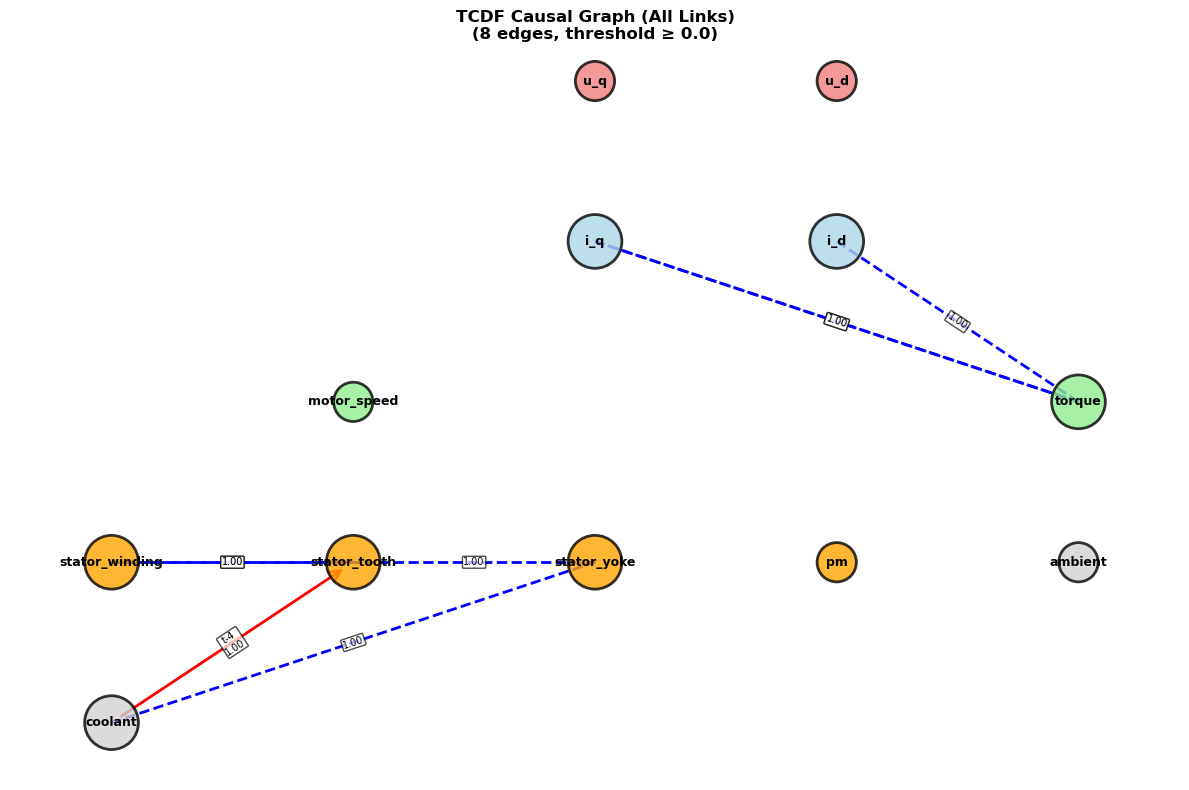

results_tigramite.csv:
   Total links: 144
   Links above threshold (0.1): 50
   Edges in graph: 31


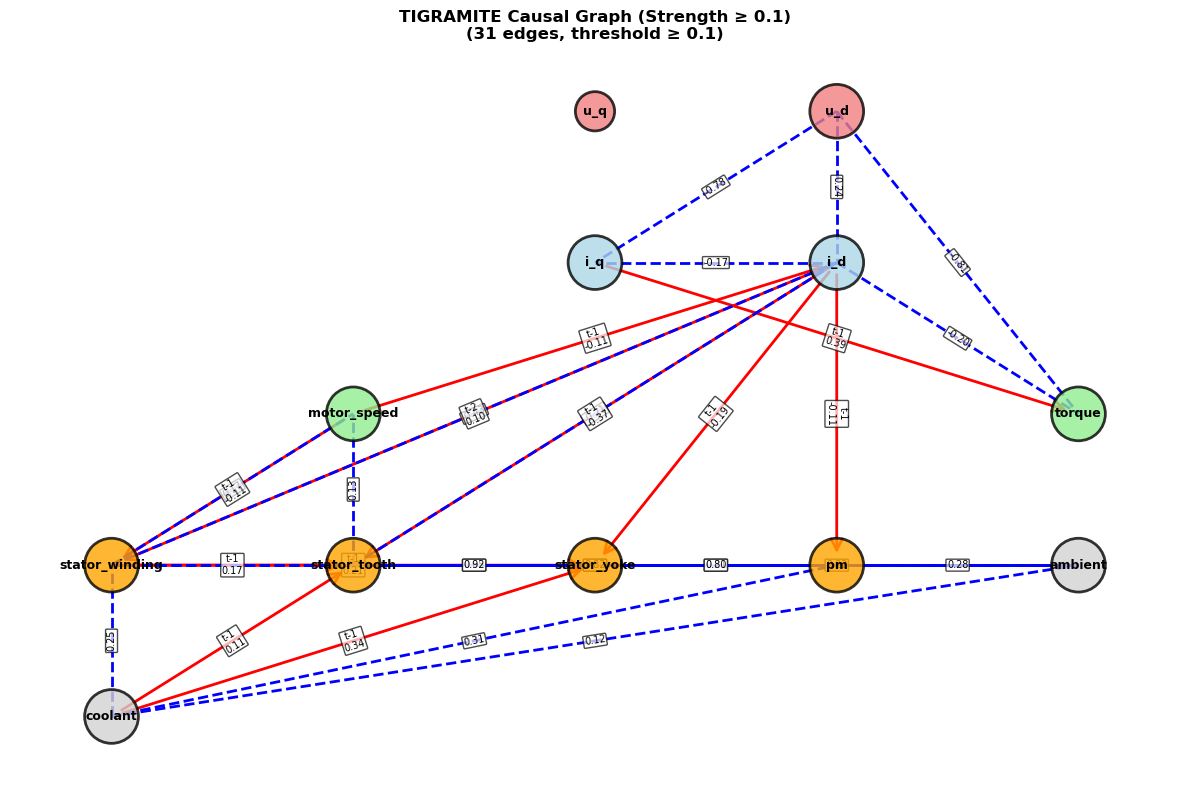

true_graph.csv:
   Total links: 31
   Links above threshold (0.0): 31
   Edges in graph: 31


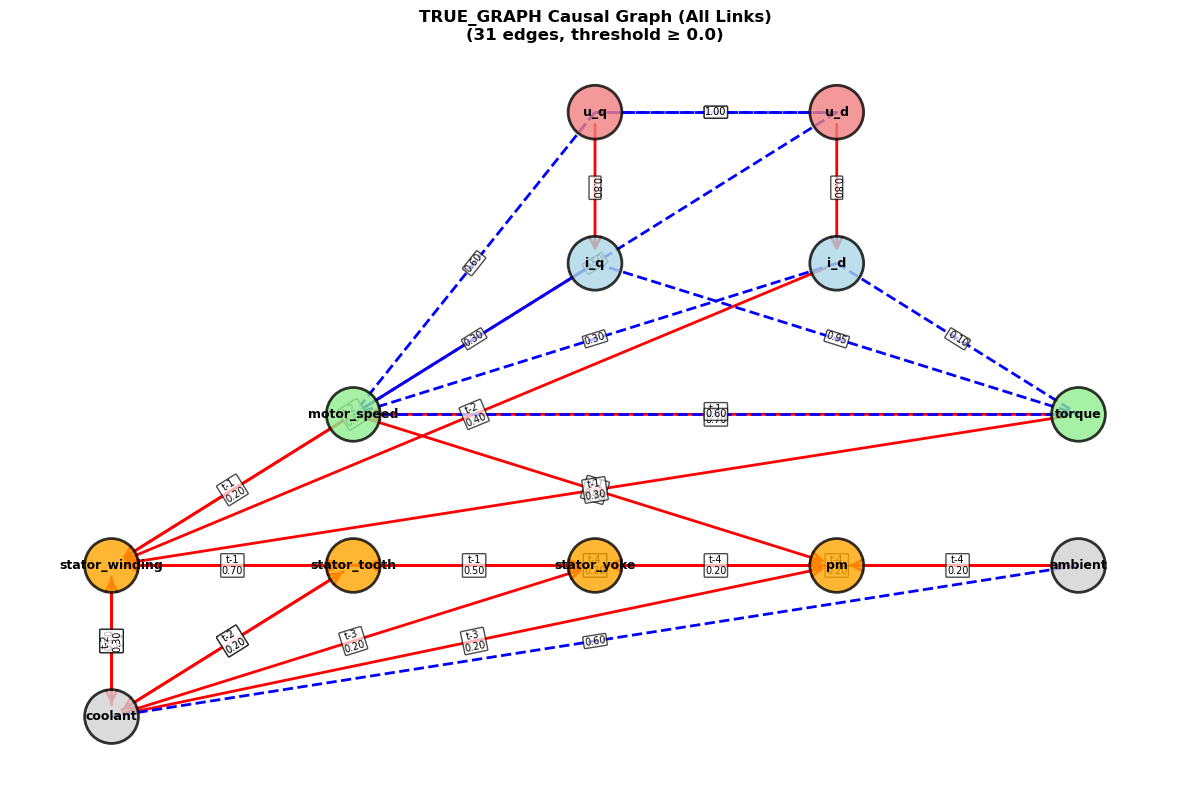


SIDE-BY-SIDE COMPARISON


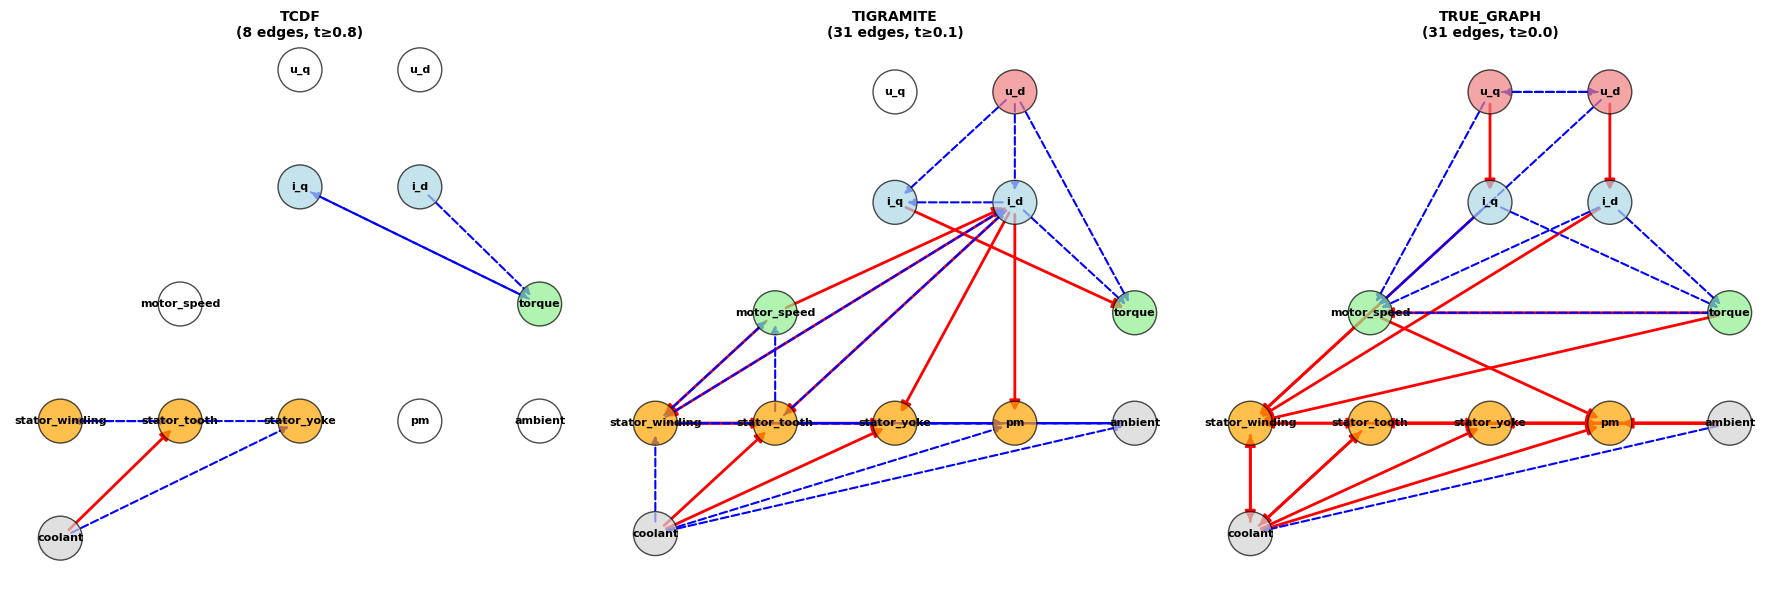

In [7]:
def create_motor_layout():
    """
    Create fixed logical layout for motor variables
    """
    motor_positions = {
        # Control inputs (top)
        'u_q': (0, 3),
        'u_d': (1, 3),
        
        # Currents (center-top)
        'i_q': (0, 2),
        'i_d': (1, 2),
        
        # Mechanical (center)
        'motor_speed': (-1, 1),
        'torque': (2, 1),
        
        # Temperatures - stator components (bottom-left)
        'stator_winding': (-2, 0),
        'stator_tooth': (-1, 0),
        'stator_yoke': (0, 0),
        
        # Temperatures - other (bottom-right)
        'pm': (1, 0),
        'coolant': (-2, -1),
        'ambient': (2, 0)
    }
    
    return motor_positions

def get_motor_variables():
    """Get standard motor variables list"""
    return ['u_q', 'u_d', 'i_q', 'i_d', 'motor_speed', 'torque', 
            'stator_winding', 'stator_tooth', 'stator_yoke', 'pm', 
            'coolant', 'ambient']

def plot_causal_graph(csv_file, threshold=0.1, title_suffix="", 
                     figsize=(12, 8), show_weights=True, save_path=None):
    """
    Plot causal graph from CSV results with fixed layout
    
    Parameters:
    -----------
    csv_file : str
        Path to CSV file with results
    threshold : float
        Minimum threshold for link strength
    title_suffix : str
        Additional text for title
    figsize : tuple
        Figure size
    show_weights : bool
        Show edge weights on graph
    save_path : str, optional
        Path to save the figure
    """
    
    # Check if file exists
    if not Path(csv_file).exists():
        print(f"File not found: {csv_file}")
        return None
    
    # Load data
    try:
        df = pd.read_csv(csv_file)
    except Exception as e:
        print(f"Error loading {csv_file}: {e}")
        return None
    
    # Filter by threshold
    df_filtered = df[abs(df['Link value']) >= threshold]
    
    print(f"{Path(csv_file).name}:")
    print(f"   Total links: {len(df)}")
    print(f"   Links above threshold ({threshold}): {len(df_filtered)}")
    
    # Create graph
    G = nx.DiGraph()
    
    # Add all motor variables to ensure consistent layout
    all_vars = get_motor_variables()
    G.add_nodes_from(all_vars)
    
    # Add any additional variables from data
    data_vars = set(df['Variable i'].tolist() + df['Variable j'].tolist())
    extra_vars = data_vars - set(all_vars)
    if extra_vars:
        G.add_nodes_from(extra_vars)
        print(f"   Extra variables: {extra_vars}")
    
    # Add edges
    edge_labels = {}
    for _, row in df_filtered.iterrows():
        source = row['Variable i']
        target = row['Variable j']
        lag = row['Time lag of i']
        weight = row['Link value']
        link_type = row.get('Link type i --- j', '-->')
        
        # Skip self-loops
        if source == target:
            continue
            
        # Add edge
        G.add_edge(source, target, 
                  weight=abs(weight), 
                  lag=lag,
                  link_type=link_type,
                  original_weight=weight)
        
        # Create edge label
        if show_weights:
            if lag > 0:
                edge_labels[(source, target)] = f"t-{lag}\n{weight:.2f}"
            else:
                edge_labels[(source, target)] = f"{weight:.2f}"
    
    print(f"   Edges in graph: {len(G.edges())}")
    
    # Create layout
    pos = create_motor_layout()
    
    # Add positions for extra variables
    extra_vars_list = [v for v in G.nodes() if v not in pos]
    if extra_vars_list:
        for i, var in enumerate(extra_vars_list):
            pos[var] = (i - len(extra_vars_list)/2, 4)
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Node styling
    node_colors = []
    node_sizes = []
    
    for node in G.nodes():
        # Color by type
        if node in ['u_q', 'u_d']:
            node_colors.append('lightcoral')
        elif node in ['i_q', 'i_d']:
            node_colors.append('lightblue')
        elif node in ['motor_speed', 'torque']:
            node_colors.append('lightgreen')
        elif 'stator' in node or node == 'pm':
            node_colors.append('orange')
        elif node in ['coolant', 'ambient']:
            node_colors.append('lightgray')
        else:
            node_colors.append('white')
        
        # Size by connectivity
        connections = G.degree(node)
        node_sizes.append(1500 if connections > 0 else 800)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_size=node_sizes, 
                          node_color=node_colors, 
                          alpha=0.8, 
                          linewidths=2,
                          edgecolors='black')
    
    # Separate edges by type
    causal_edges = [(u,v) for u,v,d in G.edges(data=True) if d.get('link_type', '-->') == '-->']
    instant_edges = [(u,v) for u,v,d in G.edges(data=True) if d.get('link_type', '-->') == 'o-o']
    
    # Draw edges
    if causal_edges:
        nx.draw_networkx_edges(G, pos, edgelist=causal_edges,
                              edge_color='red', arrows=True,
                              arrowsize=20, width=2, arrowstyle='->')
    
    if instant_edges:
        nx.draw_networkx_edges(G, pos, edgelist=instant_edges,
                              edge_color='blue', arrows=False,
                              style='dashed', width=2)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
    
    # Draw edge labels
    if show_weights and edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7,
                                    bbox=dict(boxstyle='round,pad=0.1',
                                             facecolor='white', alpha=0.7))
    
    # Title and formatting
    method_name = Path(csv_file).stem.replace('results_', '').upper()
    title = f'{method_name} Causal Graph{title_suffix}\n({len(G.edges())} edges, threshold ≥ {threshold})'
    plt.title(title, fontsize=12, fontweight='bold')
    
    plt.axis('off')
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"   Graph saved to: {save_path}")
    
    plt.show()
    
    return G

def compare_graphs_side_by_side(file1, file2, file3=None, 
                               threshold1=0.1, threshold2=0.1, threshold3=0.1,
                               figsize=(18, 6)):
    """
    Compare multiple graphs side by side with fixed layout
    
    Parameters:
    -----------
    file1, file2, file3 : str
        Paths to CSV files
    threshold1, threshold2, threshold3 : float
        Thresholds for each graph
    figsize : tuple
        Figure size
    """
    
    files = [file1, file2]
    thresholds = [threshold1, threshold2]
    titles = []
    
    # Get method names from filenames
    for f in files:
        if Path(f).exists():
            method_name = Path(f).stem.replace('results_', '').upper()
            titles.append(method_name)
        else:
            titles.append('Missing')
    
    if file3 and Path(file3).exists():
        files.append(file3)
        thresholds.append(threshold3)
        method_name = Path(file3).stem.replace('results_', '').upper()
        titles.append(method_name)
    
    n_plots = len(files)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    elif n_plots == 2:
        axes = [axes[0], axes[1]]
    
    graphs = []
    
    for i, (file, threshold, title) in enumerate(zip(files, thresholds, titles)):
        plt.sca(axes[i])
        
        if not Path(file).exists():
            plt.text(0.5, 0.5, f'File not found:\n{file}', 
                    ha='center', va='center', transform=axes[i].transAxes)
            plt.title(f'{title} (Missing)')
            axes[i].axis('off')
            graphs.append(None)
            continue
        
        # Load and process
        try:
            df = pd.read_csv(file)
            df_filtered = df[abs(df['Link value']) >= threshold]
            
            G = nx.DiGraph()
            all_vars = get_motor_variables()
            G.add_nodes_from(all_vars)
            
            # Add edges
            for _, row in df_filtered.iterrows():
                source = row['Variable i']
                target = row['Variable j']
                if source != target:
                    G.add_edge(source, target, 
                              weight=abs(row['Link value']),
                              link_type=row.get('Link type i --- j', '-->'))
            
            # Layout and draw
            pos = create_motor_layout()
            
            # Node colors
            node_colors = []
            for node in G.nodes():
                if G.degree(node) > 0:
                    if node in ['u_q', 'u_d']:
                        node_colors.append('lightcoral')
                    elif node in ['i_q', 'i_d']:
                        node_colors.append('lightblue')
                    elif node in ['motor_speed', 'torque']:
                        node_colors.append('lightgreen')
                    elif 'stator' in node or node == 'pm':
                        node_colors.append('orange')
                    else:
                        node_colors.append('lightgray')
                else:
                    node_colors.append('white')
            
            # Draw
            nx.draw_networkx_nodes(G, pos, node_size=1000, 
                                  node_color=node_colors, alpha=0.7,
                                  linewidths=1, edgecolors='black')
            
            # Edges by type
            causal_edges = [(u,v) for u,v,d in G.edges(data=True) if d.get('link_type', '-->') == '-->']
            instant_edges = [(u,v) for u,v,d in G.edges(data=True) if d.get('link_type', '-->') == 'o-o']
            
            if causal_edges:
                nx.draw_networkx_edges(G, pos, edgelist=causal_edges,
                                      edge_color='red', arrows=True, 
                                      arrowsize=15, width=2)
            if instant_edges:
                nx.draw_networkx_edges(G, pos, edgelist=instant_edges,
                                      edge_color='blue', style='dashed', width=1.5)
            
            nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
            
            plt.title(f'{title}\n({len(G.edges())} edges, t≥{threshold})', 
                     fontweight='bold', fontsize=10)
            
            graphs.append(G)
            
        except Exception as e:
            plt.text(0.5, 0.5, f'Error loading:\n{str(e)}', 
                    ha='center', va='center', transform=axes[i].transAxes)
            plt.title(f'{title} (Error)')
            graphs.append(None)
        
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return graphs

def plot_method_comparison(tcdf_file='log/results_tcdf.csv',
                          tigramite_file='log/results_tigramite.csv', 
                          ground_truth_file='log/true_graph.csv'):
    """
    Convenient function to plot all three graphs with appropriate thresholds
    """
    
    print("CAUSAL GRAPH VISUALIZATION")
    print("=" * 40)
    
    # Individual plots
    print("\n TCDF Graph:")
    G_tcdf = plot_causal_graph(tcdf_file, threshold=0.8, title_suffix=" (TCDF)")
    
    print("\n TIGRAMITE Graph:")  
    G_tigramite = plot_causal_graph(tigramite_file, threshold=0.1, title_suffix=" (TIGRAMITE)")
    
    print("\n Ground Truth:")
    G_truth = plot_causal_graph(ground_truth_file, threshold=0.0, title_suffix=" (Ground Truth)")
    
    # Side-by-side comparison
    print("\n Side-by-Side Comparison:")
    compare_graphs_side_by_side(tcdf_file, tigramite_file, ground_truth_file,
                               threshold1=0.0, threshold2=0.1, threshold3=0.0)
    
    return G_tcdf, G_tigramite, G_truth

# ===================================================================
# USAGE CELL
# ===================================================================

# Plot individual graphs
print("INDIVIDUAL GRAPH PLOTS")
print("=" * 30)

# TCDF
if Path('log/results_tcdf.csv').exists():
    plot_causal_graph('log/results_tcdf.csv', threshold=0.0, 
                     title_suffix=" (All Links)")
else:
    print("ERROR: TCDF results not found")

# TIGRAMITE  
if Path('log/results_tigramite.csv').exists():
    plot_causal_graph('log/results_tigramite.csv', threshold=0.1,
                     title_suffix=" (Strength ≥ 0.1)")
else:
    print("ERROR: TIGRAMITE results not found")

# Ground Truth
if Path('log/true_graph.csv').exists():
    plot_causal_graph('log/true_graph.csv', threshold=0.0,
                     title_suffix=" (All Links)")
else:
    print("ERROR: Ground truth not found")

print("\n" + "=" * 50)
print("SIDE-BY-SIDE COMPARISON")
print("=" * 50)

# Compare all available graphs
available_files = []
thresholds = []
if Path('log/results_tcdf.csv').exists():
    available_files.append('log/results_tcdf.csv')
    thresholds.append(0.8)
if Path('log/results_tigramite.csv').exists():
    available_files.append('log/results_tigramite.csv') 
    thresholds.append(0.1)
if Path('log/true_graph.csv').exists():
    available_files.append('log/true_graph.csv')
    thresholds.append(0.0)

if len(available_files) >= 2:
    if len(available_files) == 2:
        compare_graphs_side_by_side(available_files[0], available_files[1],
                                   threshold1=thresholds[0], threshold2=thresholds[1])
    else:
        compare_graphs_side_by_side(available_files[0], available_files[1], available_files[2],
                                   threshold1=thresholds[0], threshold2=thresholds[1], threshold3=thresholds[2])
else:
    print("ERROR: Need at least 2 result files for comparison")

CAUSAL DISCOVERY PERFORMANCE EVALUATION
CAUSAL GRAPH EVALUATION
Test Graph: 8 edges
True Graph: 31 edges

EVALUATION METRICS:
Precision:    0.2500
Recall:       0.0645
F1 Score:     0.1026
SHD:          38
BSF (α=0.5):    -0.4620

SHD BREAKDOWN:
Missing Edges:          29
Extra Edges:            6
Incorrectly Oriented:   3

-- QUICK SUMMARY:
Precision: 0.250 | Recall: 0.065 | F1: 0.103
SHD: 38 | BSF: -0.462
TCDF evaluated

CAUSAL GRAPH EVALUATION
Test Graph: 50 edges
True Graph: 31 edges

EVALUATION METRICS:
Precision:    0.1200
Recall:       0.1935
F1 Score:     0.1481
SHD:          102
BSF (α=0.5):    -0.9648

SHD BREAKDOWN:
Missing Edges:          25
Extra Edges:            44
Incorrectly Oriented:   33

-- QUICK SUMMARY:
Precision: 0.120 | Recall: 0.194 | F1: 0.148
SHD: 102 | BSF: -0.965
TIGRAMITE evaluated

PERFORMANCE SUMMARY:
--------------------------------------------------
TCDF         | P:0.250 R:0.065 F1:0.103 | SHD:38 | Edges: 8
TIGRAMITE    | P:0.120 R:0.194 F1:0.148 | SH

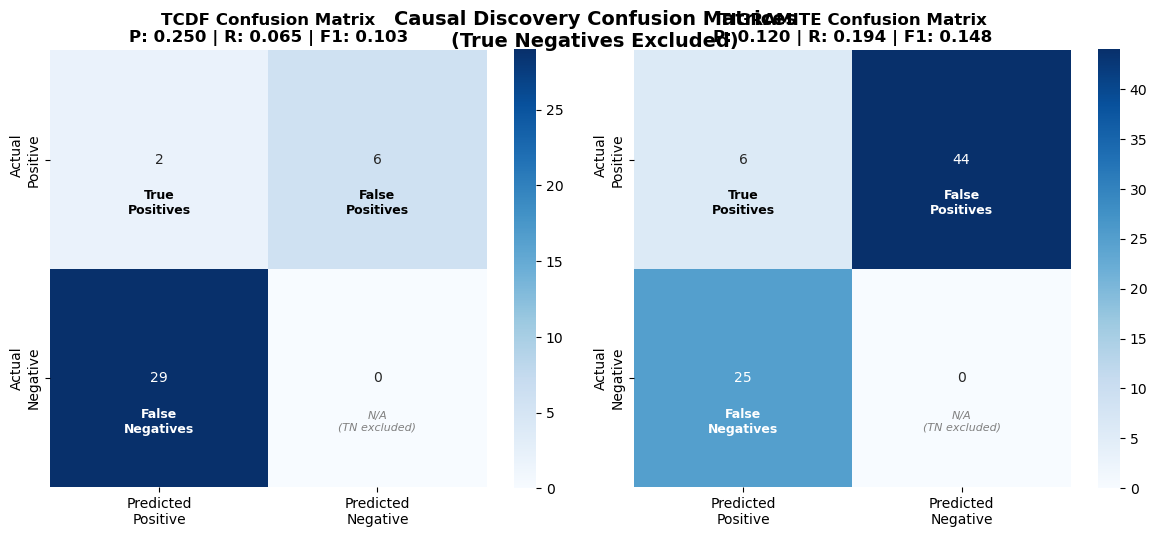

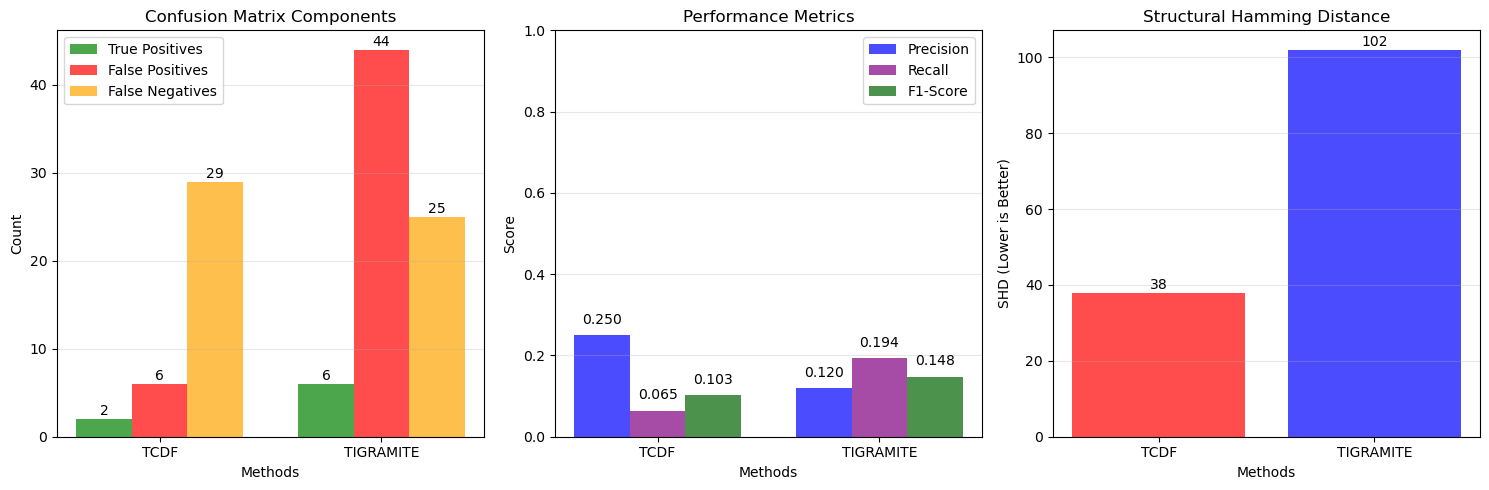


CONFUSION MATRIX SUMMARY:
----------------------------------------
TCDF         | TP:  2 FP:  6 FN: 29
TIGRAMITE    | TP:  6 FP: 44 FN: 25


In [8]:
# File paths
TCDF_FILE = 'log/results_tcdf.csv'
TIGRAMITE_FILE = 'log/results_tigramite.csv'  
GROUND_TRUTH_FILE = 'log/true_graph.csv'

print("CAUSAL DISCOVERY PERFORMANCE EVALUATION")
print("=" * 50)

# Quick evaluation with standard thresholds
results_summary = []
confusion_data = []

# TCDF evaluation
try:
    tcdf_eval = quick_evaluation(TCDF_FILE, GROUND_TRUTH_FILE, 
                                test_threshold=0.8, ignore_link_type=True)
    results_summary.append({
        'Method': 'TCDF', 
        'Threshold': 0.8,
        **{k: v for k, v in tcdf_eval.items() if k != 'threshold'}
    })
    
    # Store confusion matrix data
    confusion_data.append({
        'Method': 'TCDF',
        'TP': tcdf_eval['true_positives'],
        'FP': tcdf_eval['false_positives'], 
        'FN': tcdf_eval['false_negatives']
    })
    print("TCDF evaluated\n")
except Exception as e:
    print(f"ERROR: TCDF evaluation failed: {e}")

# Tigramite evaluation  
try:
    tigramite_eval = quick_evaluation(TIGRAMITE_FILE, GROUND_TRUTH_FILE,
                                     test_threshold=0.1, ignore_link_type=True)
    results_summary.append({
        'Method': 'TIGRAMITE',
        'Threshold': 0.15, 
        **{k: v for k, v in tigramite_eval.items() if k != 'threshold'}
    })
    
    # Store confusion matrix data
    confusion_data.append({
        'Method': 'TIGRAMITE',
        'TP': tigramite_eval['true_positives'],
        'FP': tigramite_eval['false_positives'],
        'FN': tigramite_eval['false_negatives']
    })
    print("TIGRAMITE evaluated")
except Exception as e:
    print(f"ERROR: TIGRAMITE evaluation failed: {e}")

# Performance summary table
if results_summary:
    df_summary = pd.DataFrame(results_summary)
    
    print(f"\nPERFORMANCE SUMMARY:")
    print("-" * 50)
    for _, row in df_summary.iterrows():
        method = row['Method']
        print(f"{method:12s} | P:{row['precision']:.3f} R:{row['recall']:.3f} F1:{row['f1_score']:.3f} | SHD:{row['shd']:2.0f} | Edges:{row['test_edges']:2.0f}")
    
    # Winner
    if len(df_summary) > 1:
        best_method = df_summary.loc[df_summary['f1_score'].idxmax(), 'Method']
        best_f1 = df_summary['f1_score'].max()
        print(f"\n+++ Best F1: {best_method} ({best_f1:.3f})")
    
    print(f"\nP=Precision, R=Recall, F1=F1-Score, SHD=Structural Hamming Distance")

# Confusion Matrix Visualization
if confusion_data:
    n_methods = len(confusion_data)
    
    if n_methods == 1:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        axes = [ax]
    else:
        fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))
    
    if n_methods == 1:
        axes = [axes]
    
    for i, data in enumerate(confusion_data):
        method = data['Method']
        tp, fp, fn = data['TP'], data['FP'], data['FN']
        
        # Create 2x2 confusion matrix without True Negatives
        # We'll use: [TP, FP; FN, 0] but label it properly
        conf_matrix = np.array([[tp, fp], [fn, 0]])
        
        # Custom labels for the confusion matrix
        labels = np.array([['True\nPositives', 'False\nPositives'], 
                          ['False\nNegatives', 'N/A\n(TN excluded)']])
        
        # Create heatmap
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   cbar=True, square=True, ax=axes[i],
                   xticklabels=['Predicted\nPositive', 'Predicted\nNegative'],
                   yticklabels=['Actual\nPositive', 'Actual\nNegative'])
        
        # Add text annotations with labels
        for row in range(2):
            for col in range(2):
                if not (row == 1 and col == 1):  # Skip TN cell
                    axes[i].text(col + 0.5, row + 0.7, labels[row, col], 
                               ha='center', va='center', fontsize=9, 
                               color='white' if conf_matrix[row, col] > conf_matrix.max()*0.5 else 'black',
                               weight='bold')
                else:
                    axes[i].text(col + 0.5, row + 0.7, labels[row, col], 
                               ha='center', va='center', fontsize=8, 
                               color='gray', style='italic')
        
        # Calculate performance metrics for title
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        axes[i].set_title(f'{method} Confusion Matrix\n'
                         f'P: {precision:.3f} | R: {recall:.3f} | F1: {f1:.3f}', 
                         fontweight='bold', fontsize=12)
        
        # Remove default axis labels
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    
    plt.tight_layout()
    plt.suptitle('Causal Discovery Confusion Matrices\n(True Negatives Excluded)', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.show()
    
    # Additional metrics visualization
    if len(confusion_data) > 1:
        # Create comparison bar chart
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        methods = [d['Method'] for d in confusion_data]
        
        # TP, FP, FN comparison
        tp_values = [d['TP'] for d in confusion_data]
        fp_values = [d['FP'] for d in confusion_data]  
        fn_values = [d['FN'] for d in confusion_data]
        
        x = np.arange(len(methods))
        width = 0.25
        
        axes[0].bar(x - width, tp_values, width, label='True Positives', color='green', alpha=0.7)
        axes[0].bar(x, fp_values, width, label='False Positives', color='red', alpha=0.7)
        axes[0].bar(x + width, fn_values, width, label='False Negatives', color='orange', alpha=0.7)
        
        axes[0].set_xlabel('Methods')
        axes[0].set_ylabel('Count')
        axes[0].set_title('Confusion Matrix Components')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(methods)
        axes[0].legend()
        axes[0].grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for i, method in enumerate(methods):
            axes[0].text(i - width, tp_values[i] + 0.1, str(tp_values[i]), ha='center', va='bottom')
            axes[0].text(i, fp_values[i] + 0.1, str(fp_values[i]), ha='center', va='bottom')
            axes[0].text(i + width, fn_values[i] + 0.1, str(fn_values[i]), ha='center', va='bottom')
        
        # Performance metrics comparison
        precision_values = [row['precision'] for _, row in df_summary.iterrows()]
        recall_values = [row['recall'] for _, row in df_summary.iterrows()]
        f1_values = [row['f1_score'] for _, row in df_summary.iterrows()]
        
        axes[1].bar(x - width, precision_values, width, label='Precision', color='blue', alpha=0.7)
        axes[1].bar(x, recall_values, width, label='Recall', color='purple', alpha=0.7)
        axes[1].bar(x + width, f1_values, width, label='F1-Score', color='darkgreen', alpha=0.7)
        
        axes[1].set_xlabel('Methods')
        axes[1].set_ylabel('Score')
        axes[1].set_title('Performance Metrics')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(methods)
        axes[1].set_ylim(0, 1)
        axes[1].legend()
        axes[1].grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, method in enumerate(methods):
            axes[1].text(i - width, precision_values[i] + 0.02, f'{precision_values[i]:.3f}', ha='center', va='bottom')
            axes[1].text(i, recall_values[i] + 0.02, f'{recall_values[i]:.3f}', ha='center', va='bottom')
            axes[1].text(i + width, f1_values[i] + 0.02, f'{f1_values[i]:.3f}', ha='center', va='bottom')
        
        # SHD comparison (lower is better)
        shd_values = [row['shd'] for _, row in df_summary.iterrows()]
        
        colors = ['red' if method == 'TCDF' else 'blue' for method in methods]
        bars = axes[2].bar(methods, shd_values, color=colors, alpha=0.7)
        
        axes[2].set_xlabel('Methods')
        axes[2].set_ylabel('SHD (Lower is Better)')
        axes[2].set_title('Structural Hamming Distance')
        axes[2].grid(axis='y', alpha=0.3)
        
        # Add value labels
        for bar, shd in zip(bars, shd_values):
            height = bar.get_height()
            axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{int(shd)}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

else:
    print("No evaluations completed successfully.")

# Print summary statistics
if confusion_data:
    print(f"\nCONFUSION MATRIX SUMMARY:")
    print("-" * 40)
    for data in confusion_data:
        method = data['Method']
        tp, fp, fn = data['TP'], data['FP'], data['FN']
        print(f"{method:12s} | TP:{tp:3d} FP:{fp:3d} FN:{fn:3d}")

## Results Analysis: Different Failure Modes

**TCDF Performance: Excessive Conservatism**
- **Severe underdetection**: 8 detected vs 30 true edges (73% missed)
- **High precision, catastrophic recall**: 25% precision but only 6.7% recall
- **Chain relation failure**: Failed to identify critical sequential dependencies (current→torque→stator_winding)
- **Confounder blindness**: Unable to detect confounded relationships like coolant→temperature

**Tigramite Performance: Excessive Liberalism**  
- **Severe overdetection**: 50 detected vs 30 true edges (67% false positives)
- **Low precision, moderate recall**: 12% precision but 20% recall  
- **Partial chain detection**: Identified current→torque but missed downstream stator_winding dependency
- **Confounder capability**: Successfully detected dominant coolant→temperature relationship

**Domain-Specific Analysis**:

**Chain Relations**: Both methods struggled with multi-step causal pathways (current→torque→stator_winding), a critical limitation for understanding motor dynamics where energy conversion follows sequential stages.

**Physically Plausible Discoveries**: Tigramite demonstrated superior capability in identifying thermodynamically reasonable relationships (current→temperature, coolant→temperature) despite overall poor precision.

**Comparative Analysis**:

| Method | Detected Edges | Chain Relations | Confounder Detection | Physical Plausibility |
|--------|---------------|-----------------|---------------------|----------------------|
| TCDF | 8 | Minimal | Failed | Limited |
| Tigramite | 50 | Partial | Successful | Moderate |

**Critical Assessment**:

Despite architectural improvements, **TCDF remains fundamentally limited**. The conservative bias suggests deeper issues in the inference mechanism and training methodology rather than just attention architecture flaws. The inability to handle confounders and chain relations indicates that the temporal convolution approach may be inherently unsuited for complex dynamic systems.

**Tigramite**, while producing excessive false positives, demonstrates **conceptual understanding** of motor physics through meaningful relationship detection, suggesting that constraint-based approaches may be more suitable for physical system analysis despite parameter sensitivity.

**Fundamental limitation hypothesis**: TCDF's sequence-to-sequence architecture may be optimizing for prediction accuracy rather than causal structure discovery, creating a fundamental misalignment between training objective and causal inference goals.

**Conclusion**: The results demonstrate that neither method achieves satisfactory performance for this motor system complexity, but reveal fundamentally different failure modes that illuminate the challenges of causal discovery in dynamic systems. TCDF's conservative failure suggests deeper architectural limitations beyond attention mechanism design, while Tigramite's liberal approach at least captures meaningful physical relationships despite poor precision.